In [3]:
using Distributions
using Plots, StatsPlots
using LaTeXStrings
using CSV, DataFrames

In [ ]:
resultsfile = "../data/results/TG_source/results_with_lam_0.01.csv"
df = DataFrame(CSV.File(resultsfile))

Row,ID,D,error
,String15,Float64,Float64
1,a1_left,0.07756,0.724708
2,a3_left,0.0425157,0.864359
3,a1_right,0.230212,0.500792
4,a2_left,0.219611,0.507721
5,a3_right,0.157416,0.516955
6,a4_right,0.115536,0.425244
7,a4_left,0.100241,0.417955
8,a2_right,0.0646925,0.834062


$$ \frac{m^2}{s}
= \frac{(10^3 \textrm{mm})^2}{60^{-2} \textrm{h}}
= 3600 \times 10^6 \frac{\textrm{mm}^2}{\textrm{h}}
= 3.6 \times 10^9  \frac{\textrm{mm}^2}{\textrm{h}}.$$

In [4]:
mm2perh_over_m2pers = 3.6 * 10^9

3.6e9

In [93]:
α_Gordon = 0.9
D_Gd_DTPA_m2s_Gordon_measured = 2.6 * 10^(-10)
μ_D_Gd_DTPA_m2s_Gordon = D_Gd_DTPA_m2s_Gordon_measured / α_Gordon
σ_Gordon = 0.3 * 10^(-10)

D_Gd_DTPA_mm2h = Normal(mm2perh_over_m2pers * μ_D_Gd_DTPA_m2s_Gordon, (mm2perh_over_m2pers * σ_Gordon)^2)

μ_λ_TG = 1.5
σ_TG = 0.2
λ_TG = Normal(μ_λ_TG, σ_TG^2)
μ_α_TG = 0.23 # Xie et al. 2013
σ_α_TG = 0.019 # Xie et al. 2013
α_TG = Normal(μ_α_TG, σ_α_TG^2)

Normal{Float64}(μ=0.23, σ=0.000361)

In [94]:
Ns = 1000
D_Gd_DTPA_m2s_Gordon = α_Gordon * rand(D_Gd_DTPA_mm2h, Ns)
D_Gd_DTPA_m2s_tortuos = rand(α_TG, Ns) .* rand(D_Gd_DTPA_mm2h, Ns) ./ rand(λ_TG, Ns).^2;

In [95]:
cm2pers_over_mm2perh = 10^(-2) * 60^(-2)
df.D * cm2pers_over_mm2perh * 10^7

8-element Vector{Float64}:
 2.1544453851549688
 1.1809903088481344
 6.394782601739437
 6.100304154132617
 4.372671092985181
 3.2093400048013576
 2.7844705176420335
 1.7970141230809258

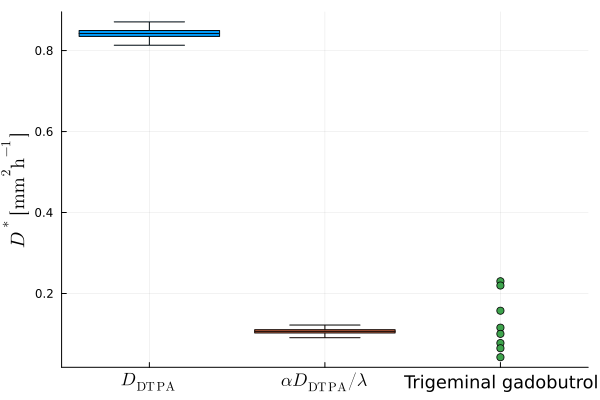

In [96]:
p = boxplot(
    [D_prior D_Gd_DTPA_m2s_tortuos],
    label="",#"prior",
    ylabel=L"D^* [\textrm{mm}^2 \textrm{h}^{-1}]",
    xticks=([
        1, 2, 3
        ],
        [
            L"D_\textrm{DTPA}",
            L" \alpha D_\textrm{DTPA} / \lambda",
            "Trigeminal gadobutrol"
        ]),
    outliers=false,
    xlims=(0.5, 3.5),
    labelfontsize=13,
    xtickfontsize=12,
)

scatter!(
    3 * ones(size(df.D)),
    df.D,
    label="",#"estimates",
)
savefig("../data/results/TG_source/fitplots/Dstar_comparison_with_GdDTPA.png")
display(p)

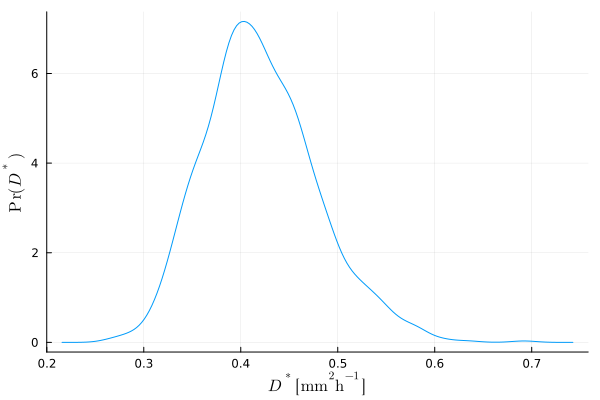

In [138]:
density(
    D_prior,
    label="",
    xlabel=L"D^* [\textrm{mm}^2 \textrm{h}^{-1}]",
    ylabel=L"\operatorname{Pr}(D^*)",
)

We can use the Stokes-Einstein equation to determine free diffusivity for DB53 and then find its effective diffusivity using Nicholson and Hrabetova's result.

$$ D = \frac{k_B \, T}{6 \pi \eta r}$$

Edited from Mestre, Tithof et al 2018, methods section: $k_B = 1.38 \times 10^{−23} \textrm m^2  \textrm{kg s}^{−2} \textrm K^{−1}$, $T = 310 \textrm K$ is the body temperature of a mouse, $\eta = 6.93 \times 10^{−4} \textrm{kg m}^{−1} \textrm s^{−1}$ is the dynamic viscosity of water at 36.8 °C, and $r = 0.888 \times 10^{−9} \textrm  m$ is the effective hydrodynamic radius for 1 kDa organic compounds (using [fluidic.com](https://www.fluidic.com/resources/Toolkit/hydrodynamic-radius-Converter/)).

In [ ]:
k_B = 1.38 * 10^(-23)
T = 310
η = 6.93 * 10^(-4)
SE_factor = k_B * T / (6 * π * η)

3.274963186854873e-19

In [ ]:
μ_r_nm = 0.2
σ²_r_nm² = 0.1
r = Normal(μ_r_nm, σ²_r_nm²) * 10^(-9)
λ = Normal(1.5, 0.1)

Normal{Float64}(μ=1.5, σ=0.1)

In [ ]:
Ns = 1000

rsamples = rand(r, Ns)
λsamples = rand(λ, Ns)

Dsamples = mm2perh_over_m2pers * SE_factor / rsamples
Dstarsamples = transpose(Dsamples) ./ λsamples.^2;